In [1]:
import my_pre_processing_routine as mpr
import pandas as pd
import numpy as np
import datalib_mt5 as dlm
import matplotlib.pyplot as plt
import matplotlib as mlt
import pickle
import time
import sqlite3
import tensorflow as tf
import thread_main_loop as tml
import thread_training
import queue
import threading
import struct
import itertools
import json
import random
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import RMSprop

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)
print(tf.__version__)

2.3.0


In [2]:
# callbacks = myCallback()
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.6):
            print("\nReached 60% accuracy so cancelling training!")
            self.model.stop_training = True

# callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

def variation_calc(a_matrix, Weight):
    line_lenght = (a_matrix.shape)[-2] - 1
    variation_matrix = []
    while line_lenght > 0:
        i = 0
        variation_line = []
        for x in a_matrix[line_lenght]:
            if abs(a_matrix[line_lenght - 1][i]) == 0.:
                a_matrix[line_lenght - 1][i] = 1
            var = (((abs(a_matrix[line_lenght][i]) / abs(a_matrix[line_lenght - 1][i])) - 1)) * Weight
            variation_line.append(var)
            i += 1
        variation_matrix.append(variation_line)
        line_lenght -= 1

    return np.array(variation_matrix)

## Parameters

In [13]:
#full_feature_list = ['t_BID','t_ASK','t_LAST','iAC','iAD','iADX','iADXWilder','iAlligator','iAMA','iAO','iATR','iBearsPower','iBands','iBullsPower','iCCI','iChaikin','iDEMA','iDeMarker','iEnvelopes','iForce','iFractals','iFrAMA','iIchimoku','iBWMFI','iMomentum','iMFI','iMA','iOsMA','iMACD','iOBV','iSAR','iRSI','iRVI','iStdDEV','iStochastic','iTEMA','iTriX','iWPR','iVIDyA','iVolumes']
shift = 10
target = 10
feature_list = ['iBands','iBullsPower','iCCI','iChaikin','iDEMA','iDeMarker','iEnvelopes','iForce','iFrAMA']
time_step = 30

## Dataset

In [3]:
dlm.insert_db()

continue(y/n)? >>>  y
continue(y/n)? >>>  y
continue(y/n)? >>>  y
continue(y/n)? >>>  n


current in: D:/Workspace/jupyter_workspace/my_advisor/db/m10_batch_1.db


new will delete currents tables.
new set (y/n)? >>>  y


In [10]:
dataset = dlm.request_table()
dataset.t_DATE.unique()

array(['2020.08.10', '2020.08.11', '2020.08.12', '2020.08.13'],
      dtype=object)

In [ ]:
x_processed

In [71]:
processed_dataset, x_processed, y_processed= mpr.process_dataset(dataset, False,  shift, target, feature_list, time_step, True)

In [ ]:
temp_X, temp_y= mpr.under_sample(x_processed, y_processed, 7)
mpr.class_lenght(temp_y)

In [64]:
x_processed, y_processed=temp_X, temp_y

## Evaluate dataset

In [4]:
dlm.insert_db()

continue(y/n)? >>>  n


current in: D:/Workspace/jupyter_workspace/my_advisor/db/temp.db


new will delete currents tables.
new set (y/n)? >>>  y


In [6]:
eval_dataset = dlm.request_table()
eval_dataset.t_DATE.unique()

array(['2020.08.14'], dtype=object)

In [67]:
eval_dataset, eval_x, eval_y= mpr.process_dataset(eval_dataset, False,  shift, target, feature_list, time_step, True)

In [37]:
temp_eval_x, temp_eval_y= mpr.under_sample(eval_x, eval_y, 9)
mpr.class_lenght(temp_eval_y)

[43, 25, 40]


In [19]:
temp_eval_x.shape

(109, 30, 9)

In [20]:
eval_x_var=[]
for element in temp_eval_x:
    eval_x_var.append(variation_calc(element,1))
eval_x_var=np.array(eval_x_var)

In [66]:
eval_x=temp_eval_x
eval_y=temp_eval_y

In [22]:
eval_x_var.shape

(109, 29, 9)

## Train test split

In [73]:
split =int(len(x_processed)*0.7)
print(split)

1421


In [74]:
#train_X, test_X, train_y, test_y = train_test_split(x_processed, y_processed, random_state = 0)
train_X, test_X, train_y, test_y = x_processed[:split], x_processed[split:], y_processed[:split], y_processed[split:]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1421, 30, 9) (1421, 1) (610, 30, 9) (610, 1)


In [25]:
train_X_var=[]
test_X_var=[]
for element in train_X:
    train_X_var.append(variation_calc(element,1))
for element in test_X:
    test_X_var.append(variation_calc(element,1))
train_X_var=np.array(train_X_var)
test_X_var=np.array(test_X_var)

In [26]:
train_X_var.shape

In [75]:
print("Final shape summary:")
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, eval_x.shape, eval_y.shape)

Final shape summary:
(1421, 30, 9) (1421, 1) (610, 30, 9) (610, 1) (452, 30, 9) (452, 1)


## Train

In [40]:
#tf.keras.layers.Activation('relu')
#model.add(tf.keras.layers.Lambda(lambda x: tf.convert_to_tensor(x),input_shape=[None]))
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(train_X[0].shape)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]))
model.add(tf.keras.layers.SimpleRNN(100, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.SimpleRNN(32))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(32,activation='relu',kernel_regularizer=tf.keras.regularizers.L1(0.001),activity_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 270)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 270)               1080      
_________________________________________________________________
lambda_1 (Lambda)            (None, 270, 1)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 270, 100)          10200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 270, 100)          0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 32)                4256      
_________________________________________________________________
batch_normalization_3 (Batch (None, 32)               

In [50]:
history = model.fit(train_X, train_y, epochs=200,batch_size=32, validation_data=(test_X, test_y),verbose=2,shuffle=False)

Epoch 1/200
13/13 - 2s - loss: 1.1328 - accuracy: 0.5947 - val_loss: 1.7061 - val_accuracy: 0.2881
Epoch 2/200
13/13 - 2s - loss: 1.1368 - accuracy: 0.6068 - val_loss: 1.7074 - val_accuracy: 0.2938
Epoch 3/200
13/13 - 2s - loss: 1.1331 - accuracy: 0.5947 - val_loss: 1.7093 - val_accuracy: 0.2938
Epoch 4/200
13/13 - 2s - loss: 1.1407 - accuracy: 0.5971 - val_loss: 1.7091 - val_accuracy: 0.2938
Epoch 5/200
13/13 - 2s - loss: 1.1318 - accuracy: 0.5922 - val_loss: 1.7095 - val_accuracy: 0.2994
Epoch 6/200
13/13 - 2s - loss: 1.1296 - accuracy: 0.6092 - val_loss: 1.7110 - val_accuracy: 0.2994
Epoch 7/200
13/13 - 3s - loss: 1.1390 - accuracy: 0.5728 - val_loss: 1.7097 - val_accuracy: 0.2994
Epoch 8/200
13/13 - 2s - loss: 1.1397 - accuracy: 0.6117 - val_loss: 1.7094 - val_accuracy: 0.2938
Epoch 9/200
13/13 - 2s - loss: 1.1438 - accuracy: 0.5898 - val_loss: 1.7091 - val_accuracy: 0.2938
Epoch 10/200
13/13 - 2s - loss: 1.1405 - accuracy: 0.5704 - val_loss: 1.7085 - val_accuracy: 0.2938
Epoch 11/

In [ ]:
model.save('models/model_id')

## Results

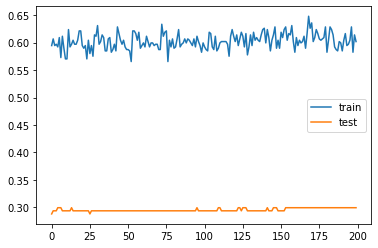

In [51]:
plt.plot(history.history['accuracy'][:], label='train')
plt.plot(history.history['val_accuracy'][:], label='test')
plt.legend()
plt.show()

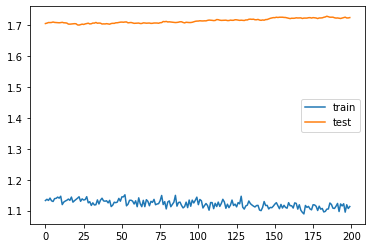

In [52]:
plt.plot(history.history['loss'][:], label='train')
plt.plot(history.history['val_loss'][:], label='test')
plt.legend()
plt.show()

In [53]:
model.evaluate(eval_x, eval_y, batch_size=32)

4/4 [==============================] - 0s 33ms/step - loss: 1.3734 - accuracy: 0.5000


[1.3733848333358765, 0.5]

## ========================================================================

## Train

In [76]:
#tf.keras.layers.Activation('relu')
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(train_X[0].shape)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]))
model.add(tf.keras.layers.LSTM(100, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(32))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(32,activation='relu',kernel_regularizer=tf.keras.regularizers.L1(0.001),activity_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(tf.keras.layers.Dense(1))

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss='mae',optimizer=optimizer,metrics=["mse"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 270)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 270)               1080      
_________________________________________________________________
lambda_2 (Lambda)            (None, 270, 1)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 270, 100)          40800     
_________________________________________________________________
dropout_2 (Dropout)          (None, 270, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                17024     
_________________________________________________________________
batch_normalization_5 (Batch (None, 32)               

In [77]:
history = model.fit(train_X, train_y, epochs=100,batch_size=32, validation_data=(test_X, test_y),verbose=2,shuffle=False)

Epoch 1/100
45/45 - 25s - loss: 7.1623 - mse: 103.5314 - val_loss: 6.2925 - val_mse: 80.3537
Epoch 2/100
45/45 - 23s - loss: 7.0880 - mse: 101.8510 - val_loss: 6.3028 - val_mse: 80.5268
Epoch 3/100
45/45 - 24s - loss: 7.0268 - mse: 100.5178 - val_loss: 6.3193 - val_mse: 80.7774
Epoch 4/100
45/45 - 23s - loss: 6.9864 - mse: 99.5686 - val_loss: 6.3398 - val_mse: 80.9984
Epoch 5/100
45/45 - 23s - loss: 6.9492 - mse: 98.6824 - val_loss: 6.3579 - val_mse: 80.9813
Epoch 6/100
45/45 - 23s - loss: 6.9179 - mse: 97.9485 - val_loss: 6.3718 - val_mse: 80.6019
Epoch 7/100
45/45 - 23s - loss: 6.8936 - mse: 97.4364 - val_loss: 6.3819 - val_mse: 80.0836
Epoch 8/100
45/45 - 23s - loss: 6.8705 - mse: 96.9039 - val_loss: 6.4078 - val_mse: 79.6314
Epoch 9/100
45/45 - 23s - loss: 6.8531 - mse: 96.4360 - val_loss: 6.4148 - val_mse: 79.1822
Epoch 10/100
45/45 - 23s - loss: 6.8336 - mse: 96.0017 - val_loss: 6.2182 - val_mse: 77.1975
Epoch 11/100
45/45 - 23s - loss: 6.8123 - mse: 95.6218 - val_loss: 7.3143 - 

In [ ]:
model.save('models/model_id')

## Results

In [ ]:
plt.plot(history.history['accuracy'][:], label='train')
plt.plot(history.history['val_accuracy'][:], label='test')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['loss'][:], label='train')
plt.plot(history.history['val_loss'][:], label='test')
plt.legend()
plt.show()

In [ ]:
model.evaluate(eval_x_var, eval_y, batch_size=32)

## Visualize

In [ ]:
ready = False

In [ ]:
#plt.imshow(train_X[index], norm=norm)
#norm = mlt.colors.Normalize(vmin=0.,vmax=1.)
layer = tf.keras.layers.LayerNormalization(axis=1)
fig=plt.figure(figsize=(18,30))
for i in range(5):
    while (not ready):
        rand = random.randint(0, len(train_y)-1)
        if np.array_equal(train_y[rand],[0., 0., 1.0]):
            plt.subplot(1,5,i+1)
            plt.subplot(1,5,i+1)
            
            output = layer(train_X_var[rand])
            plt.imshow(output)
            #plt.imshow(train_X[rand], norm=norm)
            plt.title(str(rand)+' / '+str(train_y[rand]))
            ready = True
    ready=False